In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def gamma2v (gamma):
    return np.sqrt(1.-1./(gamma**2))
def v2gamma (v):
    return 1./np.sqrt(1.-v**2)

In [61]:
# From Drappeau (2015) for GX339-4
rel_rms = 0.356 # RMS(d(gamma-1))/(<gamma>-1)
gamma_j = np.array([1.5,2,4])
# we have selected 2 in our estimations (see Overleaf)
gamma_j = 2.0

In [72]:
# calculate the speeds of two shells each rms away from the mean flow speed
gamma_sh = np.array([(2.0+rel_rms) * (gamma_j-1.0), (2.0-rel_rms) * (gamma_j-1.0)])
v_sh = gamma2v(gamma_sh)
print(gamma_sh)
print(v_sh)

[2.356 1.644]
[0.90545221 0.79372826]


In [73]:
# transform to the center-of-momentum frame
v_com = np.sum(gamma_sh*v_sh) / np.sum(gamma_sh)
print(v_com)
v_sh_com = (v_sh-v_com) / (1.0 - v_sh*v_com)
print(v_sh_com)
gamma_sh_com = v2gamma(v_sh_com)
print(gamma_sh_com)

0.8595336705469252
[ 0.20708904 -0.20708904]
[1.02215824 1.02215824]


In [74]:
# what is the relative speed of the shells
v_rel = (v_sh[1]-v_sh[0]) / (1.0 - np.product(v_sh))
print(v_rel)
gamma_rel = v2gamma(v_rel)
print(gamma_rel)

-0.3971461173219567
1.0896149535690385


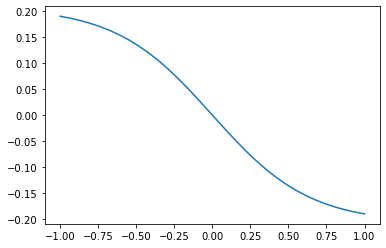

In [79]:
def sigmoid (x):
    return 1./(1.+np.exp(-x))

spread = 2.
x = np.linspace(-0.5*spread, 0.5*spread, 32)
y = sigmoid(x*(2.*np.pi/spread)) * (v_sh_com[1]-v_sh_com[0]) + v_sh_com[0]

plt.plot(x,y)
plt.show()
plt.close()

In [86]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [127]:
A0 = sym.Symbol('A_0')
a, b, c, d = sym.symbols('a b c d')
x,y = sym.symbols('x y')
x1,x2, y1,y2 = sym.symbols('x_1 x_2 y_1 y_2')
Az = sym.symbols('A_z', cls=sym.Function)(x,y)

Az = A0 * sym.cos(a*x+b) * sym.sin(c*y+d)
sym.pprint(Az)

# check boundary conditions
bcond = sym.solve(
    (
        sym.diff(Az.subs({x:x1}),y), # const on left boundary
        sym.diff(Az.subs({x:x2}),y), # const on right boundary
    ),
    (a,b)
)
sym.pprint(bcond)
isol = 3
Az = Az.subs({a:bcond[isol][0], b:bcond[isol][1]})

# choose a solution for y-periodicity
n = sym.Symbol('n')
Az = Az.subs({c:n*sym.pi/(y2-y1), d:-y1*n*sym.pi/(y2-y1)})
sym.pprint(Az)

# calculate B components
Bx = sym.diff(Az,y)
By = -sym.diff(Az,x)

# calculate the Bfield strength profile
#Bsqr = sym.diff(Az,x)**2 + sym.diff(Az,y)**2
Bsqr = Bx**2 + By**2
sym.pprint(Bsqr)

# calculate the total magnetic energy -- needed to normalize the profile and ensure fair comparison
# might need to do this numerically in the problem gen
#Btot = sym.integrate(Bsqr, (x,x1,x2), (y,y1,y2))
#sym.pprint(Btot)

sym.print_ccode(Az)

A₀⋅sin(c⋅y + d)⋅cos(a⋅x + b)
⎡⎛   π⎞  ⎛   3⋅π⎞  ⎛  -π     π⋅(3⋅x₁ - x₂)⎞  ⎛   π     π⋅(x₁ - 3⋅x₂)⎞⎤
⎢⎜0, ─⎟, ⎜0, ───⎟, ⎜───────, ─────────────⎟, ⎜───────, ─────────────⎟⎥
⎣⎝   2⎠  ⎝    2 ⎠  ⎝x₁ - x₂   2⋅(x₁ - x₂) ⎠  ⎝x₁ - x₂   2⋅(x₁ - x₂) ⎠⎦
      ⎛ π⋅n⋅y      π⋅n⋅y₁ ⎞    ⎛  π⋅x     π⋅(x₁ - 3⋅x₂)⎞
A₀⋅sin⎜──────── - ────────⎟⋅cos⎜─────── + ─────────────⎟
      ⎝-y₁ + y₂   -y₁ + y₂⎠    ⎝x₁ - x₂    2⋅(x₁ - x₂) ⎠
 2   2  2    2⎛  π⋅x     π⋅(x₁ - 3⋅x₂)⎞    2⎛ π⋅n⋅y      π⋅n⋅y₁ ⎞    2   2    
π ⋅A₀ ⋅n ⋅cos ⎜─────── + ─────────────⎟⋅cos ⎜──────── - ────────⎟   π ⋅A₀ ⋅sin
              ⎝x₁ - x₂    2⋅(x₁ - x₂) ⎠     ⎝-y₁ + y₂   -y₁ + y₂⎠             
───────────────────────────────────────────────────────────────── + ──────────
                                     2                                        
                           (-y₁ + y₂)                                         

2⎛  π⋅x     π⋅(x₁ - 3⋅x₂)⎞    2⎛ π⋅n⋅y      π⋅n⋅y₁ ⎞
 ⎜─────── + ─────────────⎟⋅sin ⎜──────── - ────────⎟
 ⎝x₁ -

100%|██████████| 256/256 [00:00<00:00, 271146.93it/s]

     2    2         2                     2    2         2                 
1.0⋅π ⋅sin (π⋅y)⋅sin (1.0⋅π⋅x - 2.0⋅π) + π ⋅cos (π⋅y)⋅cos (1.0⋅π⋅x - 2.0⋅π)



/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/ppjanka/anaconda3/envs/intsh2/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


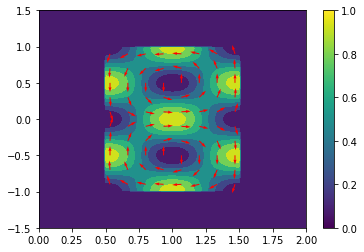

In [125]:
# set values
x1ex = 0.5
x2ex = 1.5
y1ex = -1
y2ex = 1
nex = 2
A0ex = 1

# generate variables as functions from symbolic data
Bx_ex = Bx.subs({x1:x1ex, x2:x2ex, y1:y1ex,y2:y2ex, n:nex, A0:A0ex})
By_ex = By.subs({x1:x1ex, x2:x2ex, y1:y1ex,y2:y2ex, n:nex, A0:A0ex})
Bsqr_ex = Bsqr.subs({x1:x1ex, x2:x2ex, y1:y1ex,y2:y2ex, n:nex, A0:A0ex})
sym.pprint(Bsqr_ex)

calc_Bx = sym.utilities.lambdify((x,y), Bx_ex)
calc_By = sym.utilities.lambdify((x,y), By_ex)
calc_Bsqr = sym.utilities.lambdify((x,y), Bsqr_ex)

# prepare parameter space
xlin = np.linspace(0.,2.,128)
ylin = np.linspace(-1.5,1.5,128)
xm, ym = list(map(lambda x : x.flatten(), np.meshgrid(xlin,ylin,indexing='ij')))
vecshape = (16,16)
xlinvec = np.linspace(0.,2.,vecshape[0])
ylinvec = np.linspace(-1.5,1.5,vecshape[1])
xmv, ymv = list(map(lambda x : x.flatten(), np.meshgrid(xlinvec,ylinvec,indexing='ij')))

# calculate variables
Bx_vals = np.array([calc_Bx(xx,yy) if (xx > x1ex and xx < x2ex and yy > y1ex and yy < y2ex) else 0.0 for (xx,yy) in tqdm(zip(xmv, ymv), total=len(xmv))])
By_vals = np.array([calc_By(xx,yy) if (xx > x1ex and xx < x2ex and yy > y1ex and yy < y2ex) else 0.0 for (xx,yy) in tqdm(zip(xmv, ymv), total=len(xmv))])
Bsqr_vals = np.array([calc_Bsqr(xx,yy) if (xx > x1ex and xx < x2ex and yy > y1ex and yy < y2ex) else 0.0 for (xx,yy) in tqdm(zip(xm, ym), total=len(xm))])
Bsqr_vals_vec = np.array([calc_Bsqr(xx,yy) if (xx > x1ex and xx < x2ex and yy > y1ex and yy < y2ex) else 0.0 for (xx,yy) in tqdm(zip(xmv, ymv), total=len(xmv))])

# plot the data
plt.figure()
# plot Bfield sqr
plt.tricontourf(xm,ym, Bsqr_vals)
# plot Bfield direction
arrow_size = 0.1
plt.quiver(
    *np.meshgrid(xlinvec,ylinvec,indexing='ij'),
    (arrow_size * Bx_vals / np.sqrt(Bsqr_vals_vec)).reshape(vecshape),
    (arrow_size * By_vals / np.sqrt(Bsqr_vals_vec)).reshape(vecshape),
    color='r'
)
plt.colorbar()
plt.show()
plt.close()